In [ ]:
pip install pafy youtube-dl

     |████████████████████████████████| 1.9MB 36.3MB/s 


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('drive/MyDrive/UCF50')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'drive/MyDrive/UCF50/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'drive/MyDrive/UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "drive/MyDrive/UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "HorseRace"]

model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: HorseRace


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
n_steps, n_length = 64, 64
n_features = features_train.shape[3]
features_train_lstm = features_train.reshape((features_train.shape[0], n_steps, n_length, n_features))
features_test_lstm = features_test.reshape((features_test.shape[0], n_steps, n_length, n_features))

In [ ]:
# Let's create a function that will construct our model
def create_model():

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5)) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(model_output_size, activation='softmax'))
    
    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 62, 64)      640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 60, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 60, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 30, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1920)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               808400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

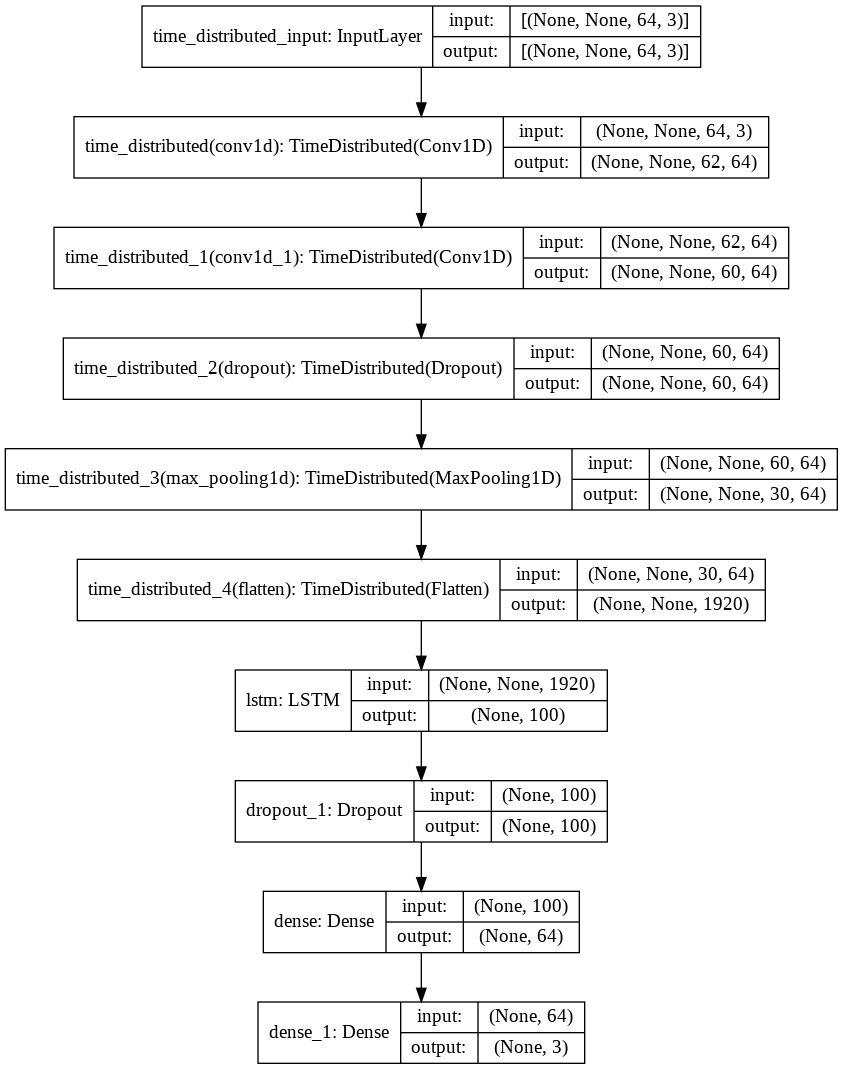

In [ ]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
3840/3840 [==============================] - 61s 7ms/step - loss: 0.4602 - accuracy: 0.8077 - val_loss: 0.0998 - val_accuracy: 0.9620
Epoch 2/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.1258 - accuracy: 0.9590 - val_loss: 0.0722 - val_accuracy: 0.9771
Epoch 3/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.0617 - accuracy: 0.9805 - val_loss: 0.0920 - val_accuracy: 0.9740
Epoch 4/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.0529 - accuracy: 0.9852 - val_loss: 0.0258 - val_accuracy: 0.9914
Epoch 5/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.0414 - accuracy: 0.9895 - val_loss: 0.0733 - val_accuracy: 0.9766
Epoch 6/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.0458 - accuracy: 0.9863 - val_loss: 0.0227 - val_accuracy: 0.9924
Epoch 7/50
3840/3840 [==============================] - 28s 7ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.1284 - val_ac

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

150/150 [==============================] - 2s 9ms/step - loss: 0.0096 - accuracy: 0.9977


In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

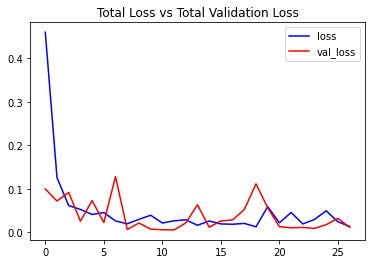

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

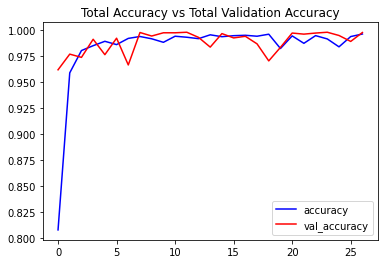

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [ ]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Setting the Widow Size which will be used by the Rolling Averge Process
window_size = 25

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Averge Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

In [ ]:
# Downloading The YouTube Video Taichi
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ceRjxW4MpOY', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Downloading The YouTube Video    Swinging
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ayI-e3cJM-0', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 1e+02
CLASS NAME: HorseRace   AVERAGED PROBABILITY: 0.14
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 0.00019


100%|██████████| 1650/1650 [00:24<00:00, 67.86it/s]


In [ ]:
# Downloading The YouTube Video Walking with dog
video_title = download_youtube_videos('https://www.youtube.com/watch?v=XqqpZS0c1K0', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 1e+02
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 0.0025
CLASS NAME: HorseRace   AVERAGED PROBABILITY: 0.00046


100%|██████████| 1651/1651 [00:23<00:00, 69.40it/s]


In [ ]:
# Downloading The YouTube Video Horse Race
video_title = download_youtube_videos('https://www.youtube.com/watch?v=WHBu6iePxKc', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
#VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: HorseRace   AVERAGED PROBABILITY: 7.4e+01
CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 2.6e+01
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 0.77


In [ ]:
# Downloading The YouTube Video    PUSH UP
video_title = download_youtube_videos('https://www.youtube.com/watch?v=WkRyOOQCVbo', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
#VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 9.7e+01
CLASS NAME: HorseRace   AVERAGED PROBABILITY: 2.7
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 0.26


In [ ]:
# Downloading The YouTube Video    PUNCHES FLOYD MAYWEATHER VS LOGAN PAUL
video_title = download_youtube_videos('https://www.youtube.com/watch?v=Ez-VyzxMuwE', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
#VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: Swing   AVERAGED PROBABILITY: 8.9e+01
CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 9.7
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 1.6
CLASS NAME: HorseRace   AVERAGED PROBABILITY: 0.15


In [ ]:
# Downloading The YouTube Video    PUNCHES Top punches
video_title = download_youtube_videos('https://www.youtube.com/watch?v=Q25FmysqXR0', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
#VideoFileClip(input_video_file_path).ipython_display(width = 700)


CLASS NAME: Swing   AVERAGED PROBABILITY: 7.7e+01
CLASS NAME: WalkingWithDog   AVERAGED PROBABILITY: 1.7e+01
CLASS NAME: TaiChi   AVERAGED PROBABILITY: 5.2
CLASS NAME: HorseRace   AVERAGED PROBABILITY: 0.085
